In [3]:
# Pull data from the concatenated files for diff runs
import pickle
import numpy as np
from utils.dataset_helpers import get_dataset
from dataset import MovieLensDataset
from tqdm.notebook import tqdm
mltiny_config = {'n_runs': 5, 'checks': False, 'init_pct': .1, 
        'test_pct': .4, 'init_mode': 'user_subset', 'batch_size': 1000,
        'step_size': 250,
        'rank_opt': 30, 'split_num': 1, 'n_acquisitions': 20000,
          'feat_pct': .5, 'user_pct': .5, 'l': 0, 'global_goal': .85} 

expmt = '20000_0.1_1_0.5_0.5_uniform_uniform_0.0_30_False_1000_5'
dataset_name = 'ml-20m-tiny'
X = MovieLensDataset(dataset_name, mltiny_config).X
init_idxs_pth = './results/' + dataset_name + '/Weighted/' + expmt + '/init_mats.pkl'
obse_idxs_pth = './results/' + dataset_name + '/Weighted/' + expmt + '/observed_mats.pkl'

Split users
Mapped uid to mids
Built known idxs
Built unknown idxs


In [4]:
obse_idxs = pickle.load(open(obse_idxs_pth, 'rb'))
init_idxs = pickle.load(open(init_idxs_pth, 'rb'))
n_runs = len(obse_idxs)
print("# of Runs: ", n_runs)

# of Runs:  5


In [27]:
def get_user_cost(n_users, obse_idx):
    user_cost = np.zeros(n_users)
    user_feature_map = []
    for idx in obse_idx:
        user_cost[idx[0]] += 1
    return user_cost

def get_high_freq_users(X, n_users, n_feats, obse_idx):
    n_features = X.shape[1]
    user_cost = get_user_cost(n_users, obse_idx)
    return np.where(user_cost >= n_feats/2)[0]

In [28]:
n_unique = np.zeros(len(obse_idxs))
n_total = np.zeros(len(obse_idxs))
n_users = X.shape[0]
n_feats = X.shape[1]
all_high_freq_users = []
for i in tqdm(range(len(obse_idxs))):
    obse_idx = obse_idxs[i]
    obse_idx = set_to_array(np.expand_dims(obse_idx, 0)[0])
    high_freq_users = get_high_freq_users(X, n_users, n_feats, obse_idx)
    all_high_freq_users.extend(list(high_freq_users))
    n_unique[i] = len(set(all_high_freq_users))
    n_total[i] = len(all_high_freq_users)
    

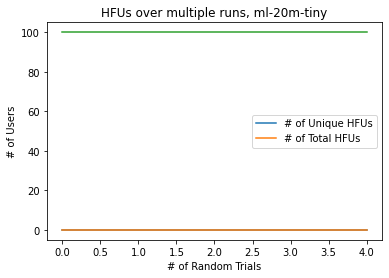

In [29]:
import matplotlib.pyplot as plt
plt.plot(np.arange(n_runs), n_unique, label="# of Unique HFUs")
plt.plot(np.arange(n_runs), n_total, label='# of Total HFUs')
plt.plot(np.arange(n_runs), [n_users for i in range(n_runs)])
plt.title("HFUs over multiple runs, " + dataset_name)
plt.xlabel("# of Random Trials")
plt.ylabel("# of Users")
plt.legend()

Text(0, 0.5, 'P(HFU)')

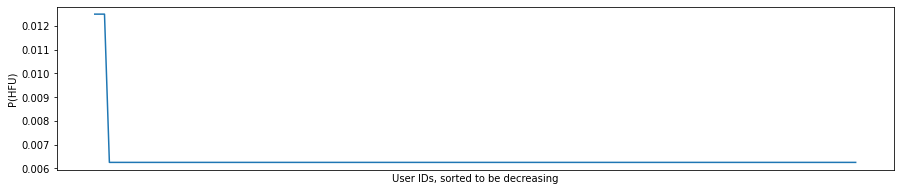

In [14]:
# Plot every user's likelihood of being a superuser
from collections import Counter
ctr = Counter(all_high_freq_users)
plt.figure(figsize=(15,3))
n_hfus = len(set(all_high_freq_users))
plt.plot(np.arange(n_hfus), np.array(ctr.most_common())[:,1]/len(all_high_freq_users))
plt.xticks([])
plt.xlabel("User IDs, sorted to be decreasing")
plt.ylabel("P(HFU)")

In [15]:
# top 10% highest exploited users
hfu_ids = np.array(ctr.most_common(40))[:,0]

In [16]:
n_users

4000

# Plotting user groups

## How many groups are in this dataset?

In [17]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
X = get_dataset(dataset_name)

def calculate_WSS(points, kmax):
    sse = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0

        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2

        sse.append(curr_sse)
    return sse

sse = calculate_WSS(X, 40)

Text(0.5, 1.0, 'WCSS vs. # of clusters, three_blobs')

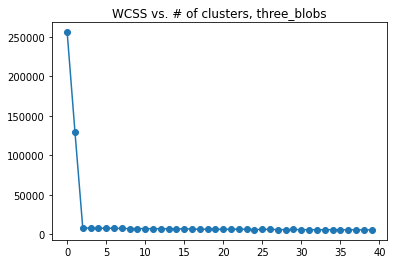

In [18]:
plt.plot(np.arange(40), sse, marker='o')
plt.title("WCSS vs. # of clusters, "+  dataset_name)

## Do these clusters show up in the TSNE embeddings? and where do HFUs fall?

Text(0.5, 1.0, 'three_blobs')

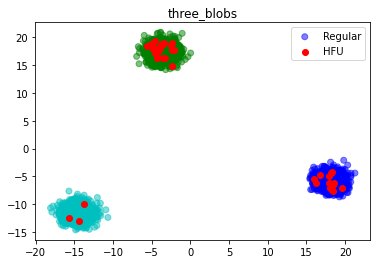

In [19]:
# Perform dimensionality reduction
from sklearn.manifold import TSNE
pca = PCA(n_components=2, svd_solver='full')
X_t = pca.fit_transform(X)

# Perform KMeans on fully observed data
kmeans = KMeans(n_clusters=3).fit(X)
centroids = kmeans.cluster_centers_
pred_clusters = kmeans.predict(X)

c = ['g' for i in range(n_users)]
for hfu_id in hfu_ids:
    c[hfu_id] = 'r'
cluster_map = {0: 'b', 1: 'g', 2: 'c'}
colors = [cluster_map[x] for x in pred_clusters]
plt.scatter(X_t[:,0], X_t[:,1], color=colors, alpha=.5, label='Regular')
plt.scatter(X_t[hfu_ids,0], X_t[hfu_ids,1], color='r', label='HFU')
plt.legend()
plt.title(dataset_name)

Text(0.5, 1.0, 'three_blobs')

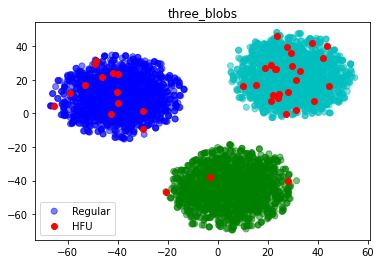

In [20]:
# Perform dimensionality reduction
from sklearn.manifold import TSNE
X_t = TSNE(n_components=2).fit_transform(X)

# Perform KMeans on fully observed data
kmeans = KMeans(n_clusters=3).fit(X)
centroids = kmeans.cluster_centers_
pred_clusters = kmeans.predict(X)

c = ['g' for i in range(n_users)]
for hfu_id in hfu_ids:
    c[hfu_id] = 'r'

cluster_map = {0: 'b', 1: 'g', 2: 'c'}
colors = [cluster_map[x] for x in pred_clusters]

plt.scatter(X_t[:,0], X_t[:,1], color=colors, alpha=.5, label='Regular')
plt.scatter(X_t[hfu_ids,0], X_t[hfu_ids,1], color='r', label='HFU')
plt.legend()
plt.title(dataset_name)


## Do the HFUs correspond to clusters?

Text(0.5, 1.0, 'three_blobs')

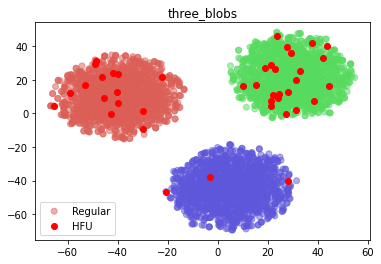

In [28]:
# Thus far these graphs show which users are most frequently "targeted" over random initializations of the data


import seaborn as sns
hfu_ids_run = get_high_freq_users(n_users, n_feats, obse_idxs[0])
n_ids = 3

kmeans = KMeans(n_clusters=n_ids).fit(X)
pred_clusters = kmeans.predict(X)

color_map = sns.color_palette("hls", n_ids)
colors = [color_map[x-1] for x in pred_clusters]

plt.scatter(X_t[:,0], X_t[:,1], color=colors, alpha=.5, label='Regular')
plt.scatter(X_t[hfu_ids_run,0], X_t[hfu_ids_run,1], color='r', label='HFU')
plt.legend()
plt.title(dataset_name)

In [268]:
n_ids

19